In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import math
from sklearn.preprocessing import OneHotEncoder

pd.set_option('display.max_rows', 1000000)
pd.set_option('display.max_columns', 1000000)

In [2]:
df_demographics = pd.read_csv('dunnhumby-the-complete-journey/hh_demographic.csv')
df_demographics.head()

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


In [11]:
df_transactions = pd.read_csv('dunnhumby-the-complete-journey/transaction_data.csv')
print('number of all transactions: ' +str(df_transactions.shape[0]))
df_transactions = df_transactions[['household_key', 'BASKET_ID', 'DAY', 'PRODUCT_ID',
       'SALES_VALUE', 'STORE_ID', 'TRANS_TIME', 'WEEK_NO']]
df_transactions.head()

number of all transactions: 2595732


,household_key,BASKET_ID,DAY,PRODUCT_ID,SALES_VALUE,STORE_ID,TRANS_TIME,WEEK_NO
0,2375,26984851472,1,1004906,1.39,364,1631,1
1,2375,26984851472,1,1033142,0.82,364,1631,1
2,2375,26984851472,1,1036325,0.99,364,1631,1
3,2375,26984851472,1,1082185,1.21,364,1631,1
4,2375,26984851472,1,8160430,1.50,364,1631,1


In [63]:
lookup_table = df_transactions[['household_key','BASKET_ID','DAY','WEEK_NO','TRANS_TIME']].drop_duplicates()
lookup_table.head()

,household_key,BASKET_ID,DAY,WEEK_NO,TRANS_TIME
0,2375,26984851472,1,1,1631
5,2375,26984851516,1,1,1642
11,1364,26984896261,1,1,1520
16,1130,26984905972,1,1,1340
21,1173,26984945254,1,1,2042


In [4]:
df_product = pd.read_csv('dunnhumby-the-complete-journey/product.csv')


In [13]:
gas_product_ids = df_product[df_product['SUB_COMMODITY_DESC'] == "GASOLINE-REG UNLEADED"]['PRODUCT_ID'].tolist()
print('number of products that are fuel: ' +str(len(gas_product_ids)))

number of products that are fuel: 35


In [49]:
fuel_transactions = df_transactions[df_transactions['PRODUCT_ID'].isin(gas_product_ids)]
print('number of transactions where fuel is purchased: ' + str(fuel_transactions.shape[0]))
print('number of households that have purchased fuel: ' + str(fuel_transactions.household_key.nunique()))
print('number of stores that sell fuel: ' + str(fuel_transactions.STORE_ID.nunique()))

fuel_basket_ids = fuel_transactions['BASKET_ID'].unique()
print('number of baskets that have fuel in it: ' +str(len(fuel_basket_ids)))


number of transactions where fuel is purchased: 24962
number of households that have purchased fuel: 1438
number of stores that sell fuel: 164
number of baskets that have fuel in it: 24952


In [50]:
grocery_transactions = df_transactions[~(df_transactions['BASKET_ID'].isin(fuel_basket_ids))]
print('number of transactions (excluding fuel): ' +str(grocery_transactions.shape[0]))

grocery_basket_ids = grocery_transactions['BASKET_ID'].unique()
print('number of grocery baskets: ' +str(len(grocery_basket_ids)))




number of transactions (excluding fuel): 2569579
number of grocery baskets: 251532


In [17]:
family_bought_fuel_days = fuel_transactions[['household_key','DAY','WEEK_NO']].drop_duplicates()
print('times families bought fuel (for each family and each specific day): ' + str(family_bought_fuel_days.shape[0]))
family_bought_fuel_days.head()


times families bought fuel (for each family and each specific day): 22630


,household_key,DAY,WEEK_NO
5377,932,12,2
6212,778,13,3
6674,778,14,3
7197,778,15,3
8055,988,17,3


In [22]:
families_bought_with_fuel = family_bought_fuel_days.merge(grocery_transactions, on=('household_key', 'DAY','WEEK_NO'), how='inner')
families_bought_with_fuel.shape


(147104, 8)

In [24]:
families_bought_with_fuel.head()

,household_key,DAY,WEEK_NO,BASKET_ID,PRODUCT_ID,SALES_VALUE,STORE_ID,TRANS_TIME
0,778,13,3,27130430804,821741,4.49,310,1220
1,778,13,3,27130430804,830887,1.88,310,1220
2,778,13,3,27130430804,831628,6.86,310,1220
3,778,13,3,27130430804,839419,8.99,310,1220
4,778,13,3,27130430804,844179,4.79,310,1220


In [37]:
grocery_basket_values_on_fuel_days = pd.DataFrame(families_bought_with_fuel.groupby('BASKET_ID')['SALES_VALUE'].sum()).reset_index()
grocery_basket_values_on_fuel_days.head()



,BASKET_ID,SALES_VALUE
0,27130430804,132.35
1,27130430811,46.54
2,27130432756,32.67
3,27153896938,12.02
4,27153897482,2.00


In [40]:
fuel_basket_values = pd.DataFrame(fuel_transactions.groupby('BASKET_ID')['SALES_VALUE'].sum()).reset_index()
fuel_basket_values.head()


,BASKET_ID,SALES_VALUE
0,27115512626,2.18
1,27115512637,2.18
2,27115512697,3.20
3,27115512702,3.20
4,27130432777,5.00


In [42]:
lookup_table.head()

,household_key,BASKET_ID,DAY,WEEK_NO
0,2375,26984851472,1,1
5,2375,26984851516,1,1
11,1364,26984896261,1,1
16,1130,26984905972,1,1
21,1173,26984945254,1,1


In [84]:
fuel_lookup = lookup_table[lookup_table['BASKET_ID'].isin(fuel_basket_ids)]
grocery_lookup = lookup_table[lookup_table['BASKET_ID'].isin(grocery_basket_ids)]


In [85]:
days_merge = family_bought_fuel_days.merge(fuel_lookup, on=['household_key','DAY','WEEK_NO'])
days_merge = days_merge.merge(fuel_basket_values, on='BASKET_ID')
days_merge.rename(columns={'BASKET_ID':'fuel_basket','SALES_VALUE':'fuel_basket_value','TRANS_TIME':'fuel_trans_time'}, inplace=True)
days_merge.head()

,household_key,DAY,WEEK_NO,fuel_basket,fuel_trans_time,fuel_basket_value
0,932,12,2,27115512626,1743,2.18
1,932,12,2,27115512637,1745,2.18
2,932,12,2,27115512697,1756,3.20
3,932,12,2,27115512702,1757,3.20
4,778,13,3,27130432777,1836,5.00


In [86]:
days_merge = days_merge.merge(grocery_lookup, on=['household_key','DAY','WEEK_NO'])
days_merge = days_merge.merge(grocery_basket_values_on_fuel_days, on='BASKET_ID')
days_merge.rename(columns={'BASKET_ID':'grocery_basket','SALES_VALUE':'grocery_basket_value','TRANS_TIME':'grocery_trans_time'}, inplace=True)
days_merge.head()

,household_key,DAY,WEEK_NO,fuel_basket,fuel_trans_time,fuel_basket_value,grocery_basket,grocery_trans_time,grocery_basket_value
0,778,13,3,27130432777,1836,5.0,27130430804,1220,132.35
1,778,13,3,27130432788,1838,5.0,27130430804,1220,132.35
2,778,13,3,27130432777,1836,5.0,27130430811,1223,46.54
3,778,13,3,27130432788,1838,5.0,27130430811,1223,46.54
4,778,13,3,27130432777,1836,5.0,27130432756,1832,32.67


In [87]:
days_with_demographics = days_merge.merge(df_demographics, on='household_key', how='right')

days_with_demographics.head()


,household_key,DAY,WEEK_NO,fuel_basket,fuel_trans_time,fuel_basket_value,grocery_basket,grocery_trans_time,grocery_basket_value,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC
0,784,18.0,3.0,2.719056e+10,908.0,12.20,2.719056e+10,900.0,12.06,45-54,A,100-124K,Homeowner,Single Female,2,None/Unknown
1,784,18.0,3.0,2.719056e+10,908.0,12.20,2.719083e+10,1731.0,8.87,45-54,A,100-124K,Homeowner,Single Female,2,None/Unknown
2,784,86.0,13.0,2.800916e+10,1339.0,18.40,2.800944e+10,2108.0,13.42,45-54,A,100-124K,Homeowner,Single Female,2,None/Unknown
3,784,127.0,19.0,2.860107e+10,1458.0,16.00,2.860107e+10,2205.0,12.49,45-54,A,100-124K,Homeowner,Single Female,2,None/Unknown
4,784,182.0,27.0,2.943585e+10,1021.0,22.65,2.943585e+10,1428.0,26.98,45-54,A,100-124K,Homeowner,Single Female,2,None/Unknown


In [88]:
# https://towardsdatascience.com/feature-engineering-time-3934038e0dbe
# https://colab.research.google.com/gist/avishalom/3264bd0544ff2a5d43c58093c11c0c56/average-circle.ipynb#scrollTo=A5zr9NmGeVi7

days_with_demographics['fuel_trans_24']= days_with_demographics['fuel_trans_time']*0.01

# dealing with circular features

def getxy(hour):
    x = math.sin((180 - hour * 15)/180 * 3.141)
    y = math.cos((180 - hour * 15)/180 * 3.141)
    return x, y

days_with_demographics['fuel_trans_time_x'], days_with_demographics['fuel_trans_time_y']= zip(*days_with_demographics['fuel_trans_24'].apply(getxy))



# https://towardsdatascience.com/feature-engineering-time-3934038e0dbe
# https://colab.research.google.com/gist/avishalom/3264bd0544ff2a5d43c58093c11c0c56/average-circle.ipynb#scrollTo=A5zr9NmGeVi7

days_with_demographics['grocery_trans_24']= days_with_demographics['grocery_trans_time']*0.01

# dealing with circular features

def getxy(hour):
    x = math.sin((180 - hour * 15)/180 * 3.141)
    y = math.cos((180 - hour * 15)/180 * 3.141)
    return x, y

days_with_demographics['grocery_trans_time_x'], days_with_demographics['grocery_trans_time_y']= zip(*days_with_demographics['grocery_trans_24'].apply(getxy))





In [89]:
# !!!!------the required functions are at the bottom------!!!!

days_with_demographics['week_day'] = days_with_demographics['DAY'].apply(add_week_day_names)
days_with_demographics['week_day_num'] = days_with_demographics['DAY'].apply(add_week_day_nums)


days_with_demographics['month'] = days_with_demographics['DAY'].apply(add_month_names)
days_with_demographics['month_num'] = days_with_demographics['DAY'].apply(add_month_nums)



In [90]:
# dealing with circular features

days_with_demographics['month_24']= days_with_demographics['month_num']*2
days_with_demographics['month_x'], days_with_demographics['month_y']= zip(*days_with_demographics['month_24'].apply(getxy))

days_with_demographics['week_day_24']= days_with_demographics['week_day_num']*24/7
days_with_demographics['weekday_x'], days_with_demographics['weekday_y']= zip(*days_with_demographics['week_day_24'].apply(getxy))



In [91]:
days_with_demographics.head()

,household_key,DAY,WEEK_NO,fuel_basket,fuel_trans_time,fuel_basket_value,grocery_basket,grocery_trans_time,grocery_basket_value,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,fuel_trans_24,fuel_trans_time_x,fuel_trans_time_y,grocery_trans_24,grocery_trans_time_x,grocery_trans_time_y,week_day,week_day_num,month,month_num,month_24,month_x,month_y,week_day_24,weekday_x,weekday_y
0,784,18.0,3.0,2.719056e+10,908.0,12.20,2.719056e+10,900.0,12.06,45-54,A,100-124K,Homeowner,Single Female,2,None/Unknown,9.08,0.692039,0.721860,9.00,0.707002,0.707212,Friday,5.0,March,3.0,6.0,1.000000,0.000296,17.142857,-0.974871,0.222769
1,784,18.0,3.0,2.719056e+10,908.0,12.20,2.719083e+10,1731.0,8.87,45-54,A,100-124K,Homeowner,Single Female,2,None/Unknown,9.08,0.692039,0.721860,17.31,-0.983681,0.179919,Friday,5.0,March,3.0,6.0,1.000000,0.000296,17.142857,-0.974871,0.222769
2,784,86.0,13.0,2.800916e+10,1339.0,18.40,2.800944e+10,2108.0,13.42,45-54,A,100-124K,Homeowner,Single Female,2,None/Unknown,13.39,-0.355858,0.934540,21.08,-0.692467,-0.721450,Wednesday,3.0,May,5.0,10.0,0.499914,0.866075,10.285714,0.433807,0.901006
3,784,127.0,19.0,2.860107e+10,1458.0,16.00,2.860107e+10,2205.0,12.49,45-54,A,100-124K,Homeowner,Single Female,2,None/Unknown,14.58,-0.625143,0.780510,22.05,-0.489054,-0.872253,Tuesday,2.0,June,6.0,12.0,0.000000,1.000000,6.857143,0.974871,0.222769
4,784,182.0,27.0,2.943585e+10,1021.0,22.65,2.943585e+10,1428.0,26.98,45-54,A,100-124K,Homeowner,Single Female,2,None/Unknown,10.21,0.451577,0.892232,14.28,-0.561990,0.827144,None,NaN,August,8.0,16.0,-0.865927,0.500171,NaN,NaN,NaN


In [92]:
days_with_demographics.isna().sum()

household_key              0
DAY                      284
WEEK_NO                  284
fuel_basket              284
fuel_trans_time          284
fuel_basket_value        284
grocery_basket           284
grocery_trans_time       284
grocery_basket_value     284
AGE_DESC                   0
MARITAL_STATUS_CODE        0
INCOME_DESC                0
HOMEOWNER_DESC             0
HH_COMP_DESC               0
HOUSEHOLD_SIZE_DESC        0
KID_CATEGORY_DESC          0
fuel_trans_24            284
fuel_trans_time_x        284
fuel_trans_time_y        284
grocery_trans_24         284
grocery_trans_time_x     284
grocery_trans_time_y     284
week_day                1303
week_day_num            1303
month                    284
month_num                284
month_24                 284
month_x                  284
month_y                  284
week_day_24             1303
weekday_x               1303
weekday_y               1303
dtype: int64

In [83]:
days_with_demographics.shape

(8558, 32)

In [93]:
days_with_demographics.columns

Index(['household_key', 'DAY', 'WEEK_NO', 'fuel_basket', 'fuel_trans_time',
       'fuel_basket_value', 'grocery_basket', 'grocery_trans_time',
       'grocery_basket_value', 'AGE_DESC', 'MARITAL_STATUS_CODE',
       'INCOME_DESC', 'HOMEOWNER_DESC', 'HH_COMP_DESC', 'HOUSEHOLD_SIZE_DESC',
       'KID_CATEGORY_DESC', 'fuel_trans_24', 'fuel_trans_time_x',
       'fuel_trans_time_y', 'grocery_trans_24', 'grocery_trans_time_x',
       'grocery_trans_time_y', 'week_day', 'week_day_num', 'month',
       'month_num', 'month_24', 'month_x', 'month_y', 'week_day_24',
       'weekday_x', 'weekday_y'],
      dtype='object')

In [95]:
training_data = days_with_demographics.dropna()

X = training_data[['fuel_basket_value',
                   'AGE_DESC', 'MARITAL_STATUS_CODE',
       'INCOME_DESC', 'HOMEOWNER_DESC', 'HH_COMP_DESC', 'HOUSEHOLD_SIZE_DESC',
       'KID_CATEGORY_DESC',
                   'fuel_trans_time_x','fuel_trans_time_y','grocery_trans_time_x',
       'grocery_trans_time_y', 'month_x', 'month_y','weekday_x', 'weekday_y']]

# X = training_data[['STORE_ID',
#        'TRANS_TIME', 'previous_amount', 'days_since_last_shopping']]


y = training_data['grocery_basket_value']

In [96]:
X.dtypes

fuel_basket_value       float64
AGE_DESC                 object
MARITAL_STATUS_CODE      object
INCOME_DESC              object
HOMEOWNER_DESC           object
HH_COMP_DESC             object
HOUSEHOLD_SIZE_DESC      object
KID_CATEGORY_DESC        object
fuel_trans_time_x       float64
fuel_trans_time_y       float64
grocery_trans_time_x    float64
grocery_trans_time_y    float64
month_x                 float64
month_y                 float64
weekday_x               float64
weekday_y               float64
dtype: object

In [97]:
X = pd.get_dummies(X)


In [99]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [100]:
from sklearn import tree

clf = tree.DecisionTreeRegressor(min_impurity_decrease=0.6, max_depth=20)
clf = clf.fit(X_train, y_train)


In [101]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

predicted = clf.predict(X_test)
mae = mean_absolute_error(y_test, predicted)
print('mean absolute error: ' + str(mae))

mse = mean_squared_error(y_test, predicted)
rmse = math.sqrt(mse)
print('mean squared error: ' + str(mse))
print('root mean squared error: ' + str(rmse))

r2 = r2_score(y_test, predicted) 
print('R2: ' + str(r2))

mean absolute error: 37.3260072555757
mean squared error: 3548.955420994089
root mean squared error: 59.57310988184257
R2: -0.5618769070346512


In [102]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=5,n_estimators=200)
regr.fit(X_train, y_train)  

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [103]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

predicted = regr.predict(X_test)
mae = mean_absolute_error(y_test, predicted)
print('mean absolute error: ' + str(mae))

mse = mean_squared_error(y_test, predicted)
rmse = math.sqrt(mse)
print('mean squared error: ' + str(mse))
print('root mean squared error: ' + str(rmse))

r2 = r2_score(y_test, predicted) 
print('R2: ' + str(r2))

mean absolute error: 32.23088088487391
mean squared error: 2088.5204456917672
root mean squared error: 45.70033310263468
R2: 0.08085296459374092


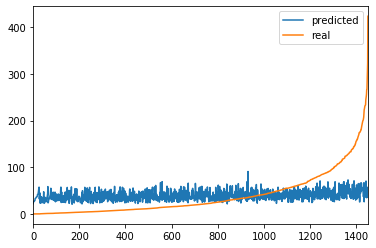

In [104]:
results = pd.DataFrame({'predicted':predicted, 'real':y_test}).sort_values(by=['real','predicted'])
results = results.reset_index().drop('index', axis=1)
results.plot()

In [77]:
def add_week_day_names(day):
    day_number = day%7
    if day_number==1:
        return 'Tuesday'
    elif day_number==2:
        return 'Wednesday'
    elif day_number==3:
        return 'Thursday'
    elif day_number==4:
        return 'Friday'
    elif day_number==5:
        return 'Saturday'
    elif day_number==6:
        return 'Sunday'
    elif day_number==0:
        return 'Monday'
    
def add_week_day_nums(day):
    day_number = day%7
    if day_number==1:
        return 2
    elif day_number==2:
        return 3
    elif day_number==3:
        return 4
    elif day_number==4:
        return 5
    elif day_number==5:
        return 6
    elif day_number==6:
        return 7
    elif day_number==0:
        return 8
    
def add_month_names(day):
    day_number = day%340
    if day_number<10:
        return 'February'
    elif day_number<40:
        return 'March'
    elif day_number<70:
        return 'April'
    elif day_number<100:
        return 'May'
    elif day_number<130:
        return 'June'
    elif day_number<160:
        return 'July'
    elif day_number<190:
        return 'August'
    elif day_number<220:
        return 'September'
    elif day_number<250:
        return 'October'
    elif day_number<280:
        return 'November'
    elif day_number<310:
        return 'December'
    elif day_number<340:
        return 'January'
    
def add_month_nums(day):
    day_number = day%340
    if day_number<10:
        return 2
    elif day_number<40:
        return 3
    elif day_number<70:
        return 4
    elif day_number<100:
        return 5
    elif day_number<130:
        return 6
    elif day_number<160:
        return 7
    elif day_number<190:
        return 8
    elif day_number<220:
        return 9
    elif day_number<250:
        return 10
    elif day_number<280:
        return 11
    elif day_number<310:
        return 12
    elif day_number<340:
        return 1